# **Skip to section 4 to see the results directly.**
*Our solution is in Qiskit defaults category.*
---

## 1 The Heisenberg Spin Model
In this Open Science Prize 2021 we are asked to simulate an Hamiltonian on the *ibmq_jakarta* quantum backend. The Hamiltonian to be considered is the *Heisenberg XXX model* for 3 spins in a line:
$$
  H = \sigma_x^{(0)} \sigma_x^{(1)} + \sigma_x^{(1)} \sigma_x^{(2)} + \sigma_y^{(0)} \sigma_y^{(1)} + \sigma_y^{(1)} \sigma_y^{(2)} + \sigma_z^{(0)} \sigma_z^{(1)} + \sigma_z^{(1)} \sigma_z^{(2)}.
$$
More specifically, we have to time evolve the state $|\psi(0)\rangle = |110\rangle$ to time $t = \pi$ under the Hamiltonian $H$. The *Schrödinger equation*
$$
  i \hbar \frac{d}{dt} |\psi(t)\rangle = H |\psi(t)\rangle,
$$
gives us (when $\hbar = 1$) the solution $|\psi(t)\rangle = U(t) \: |\psi(0)\rangle$, where $U(t)$ is the time dependent unitary:
$$
\begin{align}
  U(t) &= e^{-it H} \\
  &= \exp \Big[ -i t \big( \sigma_x^{(0)} \sigma_x^{(1)} + \sigma_x^{(1)} \sigma_x^{(2)} + \sigma_y^{(0)} \sigma_y^{(1)} + \sigma_y^{(1)} \sigma_y^{(2)} + \sigma_z^{(0)} \sigma_z^{(1)} + \sigma_z^{(1)} \sigma_z^{(2)} \big) \Big].
\end{align}
$$
Simulating the evolution of the state raises two issues:
1. The backend cannot simulate any unitary transformation, instead the backend has a finite number of available *gates*: **id**, **x**, **rz**, **sx**, **cx**. Even worst, the backend cannot apply a gate on 3 or more states. In this Open Science Prize 2021 goal is to approximate the unitary $U$ in a *circuit* simulable on the backend. We are asked to use a method called *Trotterisation*.
2. Every gate is subject to *noise* which will significantly alter the result of the transformation. Moreover, this noise is cumulative.



## 2 Trotterization
Given 2 operators $A$ and $B$ we have the property $e^{x A} e^{x B} = e^{x (A + B)}$ if and only if $[A, B] = 0$, where $[A, B]$ is the commutator of $A$ and $B$, defined by $[A, B] = A B - B A$. When $A$ and $B$ do not commute, i.e $[A, B] \neq 0$, we have a correction term that appears in the exponent of the right-hand side:
$$
  e^{x A} e^{x B} = e^{x (A + B) + \frac{1}{2} x^2 [A,B] + \mathcal{O} (x^3)}.
$$
The trotterisation consists of dividing the parameter $x$ into $N$ slices of the form
$$
  {\Big( e^{\frac{x}{N} A} e^{\frac{x}{N} B} \Big)}^N = e^{x (A + B) + \frac{1}{2} \frac{x^2}{N} [A,B] + \mathcal{O} \big( \frac{x^3}{N^2} \big)}. \tag{1}
$$
In such a way that the correction term vanishes in the limit $N \to \infty$. We refer to the product $e^{\frac{x}{N} A} e^{\frac{x}{N} B}$ as a *Trotter step*.
The Trotter formula ($1$) can be generalized for higher-order correction terms:
$$
  e^{x p_1 A} e^{x p_2 B} e^{x p_3 A} e^{x p_4 B} \cdots e^{x p_M B} = e^{x (A + B) + \mathcal{O} (x^m)}.
$$
A first improvement of the 1-step Trotter formula ($1$) is the second-order approximant $S_2 (x) = e^{\frac{x}{2} A} e^{x B} e^{\frac{x}{2} A}$.
This area of research has been intensively studied by Masuo Suzuki, who found a recursive formula for constructing higher (even) order approximants:
$$
  S_{2k} (x) = S_{2k-2} (s_k x)^2 \: S_{2k-2} ((1 - 4 s_k) x) \: S_{2k-2} (s_k x)^2,
$$
with $s_k = {\big( 4 - 4^{1 / (2k - 1)} \big)}^{-1}$.
Note that this decomposition is neither unique nor optimal!

## 3 Trotterization and Quantum simulation
In the Open Science Prize 2021, we are asked to solve the Hamiltonian simulation problem using the Trotterisation with at least 4 steps: $e^{x p_1 A} e^{x p_2 B} \cdots e^{x p_7 A} e^{x p_8 B}$. It is clear that without noise, the more steps you add, the better the approximation. It is also clear that on a noisy backend, the noise increases with the depth of the circuit. So we have to make this subtle trade-off.
In the settings of the Open Science Prize 2021, we set
$$
  A = \sigma_x^{(0)} \sigma_x^{(1)} + \sigma_y^{(0)} \sigma_y^{(1)} + \sigma_z^{(0)} \sigma_z^{(1)}, \qquad B = \sigma_x^{(1)} \sigma_x^{(2)} + \sigma_y^{(1)} \sigma_y^{(2)} + \sigma_z^{(1)} \sigma_z^{(2)}.
$$
Then each exponential $e^{x A}$ and $e^{x B}$ is again decomposed into a product of even simpler exponentials:
$$
\begin{align*}
  e^{x A} &= e^{x \sigma_x^{(0)} \sigma_x^{(1)}} \: e^{x \sigma_y^{(0)} \sigma_y^{(1)}} \: e^{\sigma_z^{(0)} \sigma_z^{(1)}} + \mathcal{O}(x^2) \\
  e^{x B} &= e^{x \sigma_x^{(1)} \sigma_x^{(2)}} \: e^{x \sigma_y^{(1)} \sigma_y^{(2)}} \: e^{\sigma_z^{(1)} \sigma_z^{(2)}} + \mathcal{O}(x^2).
\end{align*}
$$
These simpler exponentials are well known and can be implemented using the available gates of the backend:
$$
\begin{align*}
  e^{x \: \sigma_x \otimes \sigma_x} &=
  \begin{pmatrix}
       \cos(x) &          0 &            0 & -i * \sin(x) \\
             0 &    \cos(x) & -i * \sin(x) &            0 \\
             0 & -i \sin(x) &      \cos(x) &            0 \\
    -i \sin(x) &          0 &            0 &      \cos(x)
  \end{pmatrix} \\[.5em]
  e^{x \: \sigma_y \otimes \sigma_y} &=
  \begin{pmatrix}
      \cos(x) &          0 &            0 & i * \sin(x) \\
            0 &    \cos(x) & -i * \sin(x) &           0 \\
            0 & -i \sin(x) &      \cos(x) &           0 \\
    i \sin(x) &          0 &            0 &     \cos(x)
  \end{pmatrix} \\[.5em]
  e^{x \: \sigma_z \otimes \sigma_z} &=
  \begin{pmatrix}
    e^{-i x} &       0 &       0 &       0 \\
           0 & e^{i x} &       0 &       0 \\
           0 &       0 & e^{i x} &       0 \\
           0 &       0 &       0 & e^{-i x}
  \end{pmatrix}.
\end{align*}
$$

## 4 Improvements of the Trotter formula
As mentioned in section 2, the Trotter formula ($1$) is a first-order approximant, and can be generalized for higher-order correction terms:
$$
  e^{x p_1 A} e^{x p_2 B} e^{x p_3 A} e^{x p_4 B} \cdots e^{x p_M B} = e^{x (A + B) + \mathcal{O} (x^m)}.
$$
Masuo Suzuki found a second-order approximant $S_2(x)$ and a recursive formula for even-order approximants $S_{2k} (x)$.
One may ask which other second-order approximant can we find of the form:
$$
\begin{align*}
e^{x p_1 A} e^{x p_2 B} e^{x p_3 A} e^{x p_4 B} &=  e^{x (A + B) + \mathcal{O} (x^3)}.\tag{2} \\ 
e^{x p_1 A} e^{x p_2 B} e^{x p_3 B} e^{x p_4 A} &= e^{x (A + B) + \mathcal{O} (x^3)}. \tag{3}
\end{align*}
$$
Solving Eq. ($2$) give us the system of equations:
$$
\begin{cases}
  p_1 + p_3 &= 1 \\
  p_2 + p_4 &= 1 \\
  \frac{p_1^2}{2} + p_1 p_3 + \frac{p_3^2}{2} &= \frac{2}{2} \\
  p_1 p_2 + p_1 p_4 + p_3 p_4 &= \frac{1}{2} \\
  p_2 p_3 &= \frac{1}{2} \\
  \frac{p_2^2}{2} + p_2 p_4 + \frac{p_4^2}{2} &= \frac{2}{2}
\end{cases}
\quad \Longrightarrow \quad
\begin{cases}
  p_1 &= 1 - p_3 \\
  p_2 &= \frac{1}{2 p_3} \\
  p_3 &\neq 0 \\
  p_4 &= 1 - \frac{1}{2 p_3}.
\end{cases} \tag{4}
$$
Similarly solving Eq. ($3$) give us the system of equations:
$$
\begin{cases}
  p_1 + p_4 &= 1 \\
  p_2 + p_3 &= 1 \\
  \frac{p_1^2}{2} + p_1 p_4 + \frac{p_4^2}{2} &= \frac{2}{2} \\
  p_1 p_2 + p_1 p_3 &= \frac{1}{2} \\
  p_2 p_4 + p_3 p_4 &= \frac{1}{2} \\
  \frac{p_2^2}{2} + p_2 p_3 + \frac{p_3^2}{2} &= \frac{2}{2}
\end{cases}
\quad \Longrightarrow \quad
\begin{cases}
  p_1 &= \frac{1}{2} \\
  p_2 &= 1 - p_3 \\
  p_3 &\in \mathbb{R} \\
  p_4 &= \frac{1}{2}.
\end{cases} \tag{5}
$$
This defines two Trotter 4-step formulas:
$$
\begin{align*}
  \text{ABAB} &= {\Big( e^{x \frac{p_1}{2} A} e^{x \frac{p_2}{2} B} e^{x \frac{p_3}{2} A} e^{x \frac{p_4}{2} B} \Big)}^2 \\
  \text{ABBA}&= {\Big( e^{x \frac{p_1}{2} A} e^{x \frac{p_2}{2} B} e^{x \frac{p_3}{2} B} e^{x \frac{p_4}{2} A} \Big)}^2,
\end{align*}
$$
that we want to compare with the original 4-step Trotter formula
$$
  \text{Trotter} = {\Big( e^{\frac{x}{4} A} e^{\frac{x}{4} B} \Big)}^4,
$$
and the Suzuki formula
$$
  \text{Suzuki} = S_4 (x).
$$
In order to compare these formula we define the error distances to $e^{-i x (A + B)}$:
$$
  \begin{align*}
    E_{\scriptscriptstyle \text{ABAB}} (x) &= \Big{\|} e^{-i x (A + B)} - {\Big( e^{x \frac{p_1}{2} A} e^{x \frac{p_2}{2} B} e^{x \frac{p_3}{2} A} e^{x \frac{p_4}{2} B} \Big)}^2 \Big{\|} \\[.5em]
    E_{\scriptscriptstyle \text{ABBA}} (x) &= \Big{\|} e^{-i x (A + B)} - {\Big( e^{x \frac{p_1}{2} A} e^{x \frac{p_2}{2} B} e^{x \frac{p_3}{2} B} e^{x \frac{p_4}{2} A} \Big)}^2 \Big{\|} \\[.5em]
    E_{\scriptscriptstyle \text{Trotter}} (x) &= \Big{\|} e^{-i x (A + B)} - {\Big( e^{\frac{x}{4} A} e^{\frac{x}{4} B} \Big)}^4 \Big{\|} \\[.5em]
    E_{\scriptscriptstyle \text{Suzuki}} (x) &= \Big{\|} e^{-i x (A + B)} - S_4 (x) \Big{\|}.
  \end{align*}
$$
Note that for $E_{\scriptscriptstyle \text{ABAB}}$ and $E_{\scriptscriptstyle \text{ABBA}}$, the parameters $p_1, p_2, p_3, p_4$ are chosen to minimize the error while respecting the systems of equations ($4$) and ($5$). The errors are summarised in the following stacked plot. According to this heuristic, the $\text{ABAB}$ formula seems to be the most stable, and is therefore chosen to simulate the Hamiltonian in the next section. 
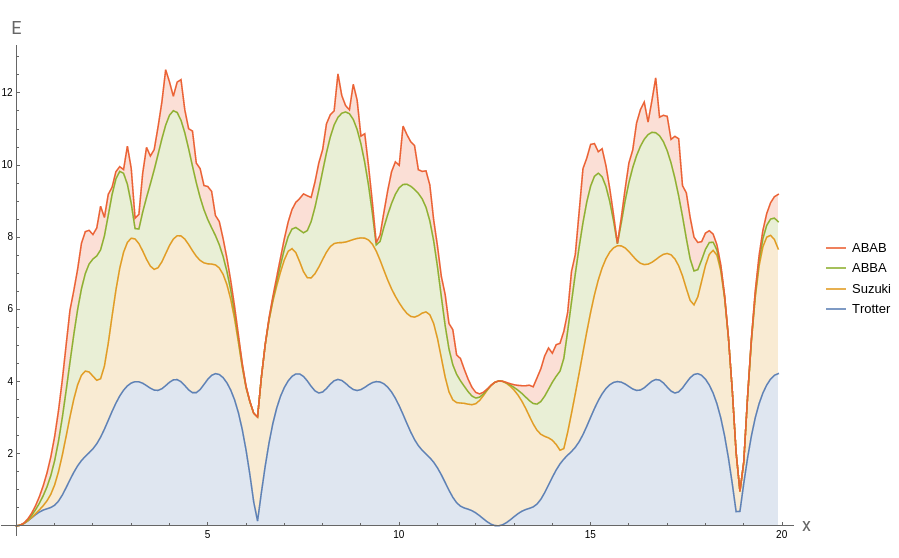

## 5 Implementation
The implementation follows mostly the notebook provided by the organizers.

### 5.1 Qiskit and Numpy imports

In [ ]:
!pip install qiskit numpy

In [2]:
# Suppress warnings (qiskit ignis is deprecated)
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from qiskit import execute, IBMQ, QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit import Parameter
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.opflow import Zero, One
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import state_fidelity
from qiskit.tools.monitor import job_monitor
from qiskit.result import Result

### 5.2 Load IBMQ Account data
Replace `TOKEN` with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)

In [ ]:
TOKEN = TOKEN
IBMQ.save_account(TOKEN, overwrite=True)
IBMQ.load_account()

### 5.3 Get backend for experiment
Returns the ibmq_jakarta noisy quantum backend, or a noisy/noiseless quantum simulator.

In [16]:
def quantum_backend(simulator, noisy):
  if not simulator and not noisy:
    raise RuntimeError("Nice try!")

  # ibmq_jakarta backend
  provider = IBMQ.get_provider(hub="ibm-q-community", group="ibmquantumawards", project="open-science-22")
  jakarta = provider.get_backend("ibmq_jakarta")
  
  if not simulator:
    return jakarta

  # Simulated backend based on ibmq_jakarta's noise profile
  jakarta_simulator = AerSimulator.from_backend(jakarta)
  
  # Noiseless simulated backend
  simulator = AerSimulator()

  if not noisy:
    return simulator
  else:
    return jakarta_simulator

### 5.4 Build XX/YY/ZZ gates
Build subcircuits for the parametrized 2-qubit gates
$$
\begin{align*}
  e^{x \cdot c \: \sigma_x \otimes \sigma_x} \\[.5em]
  e^{x \cdot c \: \sigma_y \otimes \sigma_y} \\[.5em]
  e^{x \cdot c \: \sigma_z \otimes \sigma_z}
\end{align*}
$$
where $t$ is the time parameter, and $c$ is some chosen scalar.

In [5]:
# Build a subcircuit for the XX(t*c) 2-qubit gate
def XX_gate(t, c):
  qr = QuantumRegister(2)
  qc = QuantumCircuit(qr, name="XX")
  
  qc.ry(np.pi / 2., [qr[0], qr[1]])
  qc.cnot(qr[0], qr[1])
  qc.rz(2. * t * c, qr[1])
  qc.cnot(qr[0], qr[1])
  qc.ry(-np.pi / 2., [qr[0], qr[1]])
  
  # Convert quantum circuit into a gate
  return qc.to_instruction()

# Build a subcircuit for the YY(t *c) 2-qubit gate
def YY_gate(t, c):
  qr = QuantumRegister(2)
  qc = QuantumCircuit(qr, name="YY")
  
  qc.rx(np.pi / 2., [qr[0], qr[1]])
  qc.cnot(qr[0], qr[1])
  qc.rz(2. * t * c, qr[1])
  qc.cnot(qr[0], qr[1])
  qc.rx(-np.pi / 2., [qr[0], qr[1]])
  
  # Convert quantum circuit into a gate
  return qc.to_instruction()

# Build a subcircuit for the ZZ(t *c ) 2-qubit gate
def ZZ_gate(t, c):
  qr = QuantumRegister(2)
  qc = QuantumCircuit(qr, name="ZZ")
  
  qc.cnot(qr[0], qr[1])
  qc.rz(2. * t * c, qr[1])
  qc.cnot(qr[0], qr[1])
  
  # Convert custom quantum circuit into a gate
  return qc.to_instruction()

### 5.5 Build $\text{ABAB}$ Trotter gate
Build the $\text{ABAB}$ Trotter gate from section 4, with parameters:
$$
  p_1 = 1 - p_3, \quad p_2 = \frac{1}{2 p_3}, \quad p_3 = 0.5 \enspace \text{ and } \enspace p_4 = 1 - \frac{1}{2 p_3},
$$
where $p_3$ is chosen to minimize error $E_{\text{ABAB}} (t)$ when $t = \pi$.

In [6]:
# Combine subcircuits into a single multiqubit gate representing the Trotter gate
def Trotter_gate_4_steps_custom_formula(t):
  qr = QuantumRegister(3)
  qc = QuantumCircuit(qr, name="Trotter")
 
  # Build subcircuits for the XX(t * c) / YY(t * c) / ZZ(t * c) 2-qubit gates
  XX = lambda c: XX_gate(t, c) 
  YY = lambda c: YY_gate(t, c) 
  ZZ = lambda c: ZZ_gate(t, c) 

  # Second-order approximant:
  p = 0.5 # Optimal parameter
  ps = [1. - p, 1. / (2. * p), p, 1. - 1. / (2. * p)] # Approximant formula's parameters

  # 1st Trotter step
  qc.append(XX(ps[0] / 2.), [qr[0], qr[1]])
  qc.append(YY(ps[0] / 2.), [qr[0], qr[1]])
  qc.append(ZZ(ps[0] / 2.), [qr[0], qr[1]])
  qc.append(XX(ps[1] / 2.), [qr[1], qr[2]])
  qc.append(YY(ps[1] / 2.), [qr[1], qr[2]])
  qc.append(ZZ(ps[1] / 2.), [qr[1], qr[2]])

  # 2nd trotter step
  qc.append(XX(ps[2] / 2.), [qr[0], qr[1]])
  qc.append(YY(ps[2] / 2.), [qr[0], qr[1]])
  qc.append(ZZ(ps[2] / 2.), [qr[0], qr[1]])
  qc.append(XX(ps[3] / 2.), [qr[1], qr[2]])
  qc.append(YY(ps[3] / 2.), [qr[1], qr[2]])
  qc.append(ZZ(ps[3] / 2.), [qr[1], qr[2]])

  # 3rd Trotter step
  qc.append(XX(ps[0] / 2.), [qr[0], qr[1]])
  qc.append(YY(ps[0] / 2.), [qr[0], qr[1]])
  qc.append(ZZ(ps[0] / 2.), [qr[0], qr[1]])
  qc.append(XX(ps[1] / 2.), [qr[1], qr[2]])
  qc.append(YY(ps[1] / 2.), [qr[1], qr[2]])
  qc.append(ZZ(ps[1] / 2.), [qr[1], qr[2]])

  # 4th trotter step
  qc.append(XX(ps[2] / 2.), [qr[0], qr[1]])
  qc.append(YY(ps[2] / 2.), [qr[0], qr[1]])
  qc.append(ZZ(ps[2] / 2.), [qr[0], qr[1]])
  qc.append(XX(ps[3] / 2.), [qr[1], qr[2]])
  qc.append(YY(ps[3] / 2.), [qr[1], qr[2]])
  qc.append(ZZ(ps[3] / 2.), [qr[1], qr[2]])

  # Convert custom quantum circuit into a gate
  return qc.to_instruction()

### 5.6 Tomography & Fidelity
Compute the fidelity between the result and the target states using state tomography.

In [7]:
def state_tomography_fidelity(result, target, circuits):
    # Fit state tomography result
    fitter = StateTomographyFitter(result, circuits)
    rho = fitter.fit(method="lstsq")

    # Compute fidelity
    return state_fidelity(rho, target)

### 5.7 Results without error mitigation
Replace `simulator=True` with `simulator=False` to run the simulation on the ibmq_jakarta noisy quantum backend.
> Usually we have a fidelity on noisy simulator around `0.68`

In [8]:
# Open Science Prize 2021
def open_science_prize_2021_without_error_mitigation(simulator):  
  # Get backend for experiement
  backend = quantum_backend(simulator=simulator, noisy=True)
  
  # Define the time parameter
  time = Parameter("t")
  target_time = np.pi

  # Create a quantum circuit acting with 7 qubits
  qr = QuantumRegister(7)
  qc = QuantumCircuit(qr, name="OSP21")
  
  # Initialize qubits 3 & 5 to |1⟩ and the others to |0⟩
  qc.x([qr[3], qr[5]])

  # Simulate time evolution under the XXX Heisenberg model Hamiltonian on qubits 1, 2 and 5
  qc.barrier()
  qc.append(Trotter_gate_4_steps_custom_formula(time), [qr[1], qr[3], qr[5]])
  qc.barrier()
  
  # Bind the time parameter to the target_time
  qc = qc.bind_parameters({time: target_time})
  
  # Generate state tomography circuits
  qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

  # Experiments settings 
  shots = 1024 #8192
  count = 2 #8

  # Experiments execution
  jobs = []
  for _ in range(0, count):
    # Execute the circuit on the backend
    job = execute(qcs, backend, shots=shots)
    jobs.append(job)

  # Jobs monitoring 
  for i, job in enumerate(jobs):
    print(f"Jobs monitoring: {100 * i / len(jobs):.0f}%")
    job_monitor(job, quiet=True)
  print("Jobs monitoring: 100%")

  # The target state
  target_state = (One^One^Zero).to_matrix()  # |110>

  # Compute fidelities using tomography for each repetition
  fidelities = []
  for i, job in enumerate(jobs):
      print(f"States tomography: {100 * i / len(jobs):.0f}%")
      fidelity = state_tomography_fidelity(job.result(), target_state, qcs)
      fidelities.append(fidelity)
  print("States tomography: 100%")
      
  print(f"State tomography fidelity = {np.mean(fidelities):.4f} \u00B1 {np.std(fidelities):.4f}")

In [9]:
open_science_prize_2021_without_error_mitigation(simulator=True)

Jobs monitoring: 0%
Jobs monitoring: 50%
Jobs monitoring: 100%
States tomography: 0%
States tomography: 50%
States tomography: 100%
State tomography fidelity = 0.6927 ± 0.0026


### 5.7 Results with error mitigation
We tackled the noise problem by *error mitigation* methods (see Suguru Endo's [PhD thesis](https://ora.ox.ac.uk/objects/uuid:6733c0f6-1b19-4d12-a899-18946aa5df85)).
The error mitigation methods are designed to mitigate error of an expectation value, not a quantum state itself. In this implementation we mitigate the `counts` error, use in tomography reconstruction.
In order to do that, we need some helper functions.

#### 5.7.1 Mitigated `Result`
The Open Science Prize 2021 judges the implementations according to the states fidelity, based on tomography techniques. The Qiskit tomography algorithm uses the `Result` object and specially the `counts` data.
In order to use error mitigation we write a function returning a new `Result` given mitigated `counts`.

In [10]:
def mitigates_result(result, mitigated_counts, circuits):
  for i, circuit in enumerate(circuits):
    for key in result.data(circuit)["counts"].keys():
      result.data(circuit)["counts"][key] = mitigated_counts[i][key]

  return result

#### 5.7.2 Noise boosted $\text{ABAB}$ Trotter gate
Error mitigation requires to be able to repeatedly running the circuit at different boosted noise levels. We chose to increase the number of steps in order to artificially increase the noise in the $\text{ABAB}$ Trotter gate.

In [11]:
# Combine subcircuits into a single multiqubit gate representing the Trotter gate with noise boosted
def Trotter_gate_4_steps_custom_formula_noise_boosted(t, noise_level):
  qr = QuantumRegister(3)
  qc = QuantumCircuit(qr, name="Trotter")
 
  # Build subcircuits for the XX(t * c) / YY(t * c) / ZZ(t * c) 2-qubit gates
  XX = lambda c: XX_gate(t, c) 
  YY = lambda c: YY_gate(t, c) 
  ZZ = lambda c: ZZ_gate(t, c) 

  # Second-order approximant:
  p = 0.5 # optimal parameter
  ps = [1. - p, 1. / (2. * p), p, 1. - 1. / (2. * p)] # Approximant formula's parameters

  for _ in range(0, noise_level):
    # 1st Trotter step
    qc.append(XX(ps[0] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(YY(ps[0] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(ZZ(ps[0] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(XX(ps[1] / (2. * noise_level)), [qr[1], qr[2]])
    qc.append(YY(ps[1] / (2. * noise_level)), [qr[1], qr[2]])
    qc.append(ZZ(ps[1] / (2. * noise_level)), [qr[1], qr[2]])

    # 2nd trotter step
    qc.append(XX(ps[2] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(YY(ps[2] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(ZZ(ps[2] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(XX(ps[3] / (2. * noise_level)), [qr[1], qr[2]])
    qc.append(YY(ps[3] / (2. * noise_level)), [qr[1], qr[2]])
    qc.append(ZZ(ps[3] / (2. * noise_level)), [qr[1], qr[2]])

    # 3rd Trotter step
    qc.append(XX(ps[0] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(YY(ps[0] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(ZZ(ps[0] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(XX(ps[1] / (2. * noise_level)), [qr[1], qr[2]])
    qc.append(YY(ps[1] / (2. * noise_level)), [qr[1], qr[2]])
    qc.append(ZZ(ps[1] / (2. * noise_level)), [qr[1], qr[2]])

    # 4th trotter step
    qc.append(XX(ps[2] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(YY(ps[2] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(ZZ(ps[2] / (2. * noise_level)), [qr[0], qr[1]])
    qc.append(XX(ps[3] / (2. * noise_level)), [qr[1], qr[2]])
    qc.append(YY(ps[3] / (2. * noise_level)), [qr[1], qr[2]])
    qc.append(ZZ(ps[3] / (2. * noise_level)), [qr[1], qr[2]])

  # Convert custom quantum circuit into a gate
  return qc.to_instruction()

#### 5.7.3 Sample `counts`

We sample `counts` for several noise levels in `Trotter_gate_4_steps_custom_formula_noise_boosted`.

In [12]:
def sample_counts(noise_levels, simulator):
  sampled_counts = []

  # Get backend for experiement
  backend = quantum_backend(simulator=simulator, noisy=True)
  
  # Define the time parameter
  time = Parameter("t")
  target_time = np.pi

  for i, noise_level in enumerate(noise_levels):
    print(f"Sample counts: {100 * i / len(noise_levels):.0f}%")

    # Create a quantum circuit acting with 7 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr, name="OSP21")
  
    # Initialize qubits 3 & 5 to |1⟩ and the others to |0⟩
    qc.x([qr[3], qr[5]])

    # Simulate time evolution under the XXX Heisenberg model Hamiltonian on qubits 1, 2 and 5
    qc.barrier()
    qc.append(Trotter_gate_4_steps_custom_formula_noise_boosted(time, noise_level), [qr[1], qr[3], qr[5]])
    qc.barrier()
  
    # Bind the time parameter to the target_time
    qc = qc.bind_parameters({time: target_time})
  
    # Generate state tomography circuits
    qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

    # Experiments settings 
    shots = 1024

    # Experiment execution
    job = execute(qcs, backend, shots=shots)

    # Job monitoring 
    job_monitor(job, quiet=True)
  
    # Job result
    result = job.result()

    # Sample counts
    sampled_count = []
    for circuit in qcs:
      sampled_count.append(result.data(circuit)["counts"])
    sampled_counts.append(sampled_count)
  
  print("Sample counts: 100%")
  return sampled_counts

#### 5.7.4 Polynomial extrapolation
Given sampled `counts`, we use a polynomial extrapolation to get the zero-noise limit.

In [13]:
def polynomial_extrapolation(xs, ys):
  coef = lambda i: np.prod([xs[j] / (xs[j] - xs[i]) for j in range(0, len(xs)) if not j == i])

  return np.sum([ys[i] * coef(i) for i in range(0, len(xs))])

#### 5.7.5 Results with error mitigation
Sample some `counts` using noise boosting (it can take time), then mitigate the noise error a of $\text{ABAB}$ Trotter gate.
Replace `simulator=True` with `simulator=False` to run the simulation on the ibmq_jakarta noisy quantum backend.
> Best fidelity on noisy simulator: `0.96`

In [14]:
# Open Science Prize 2021
def open_science_prize_2021_with_error_mitigation(simulator):
  # Heuristic noise levels for t = pi
  noise_levels = [1, 3, 8] # best fidelity: 0.96
  #noise_levels = [1, 3, 10] # best fidelity: 0.96
  #noise_levels = [1, 3, 11] # best fidelity: 0.96

  # Sample counts
  sampled_counts = sample_counts(noise_levels, simulator)

  # Get backend for experiement
  backend = quantum_backend(simulator=simulator, noisy=True)
  
  # Define the time parameter
  time = Parameter("t")
  target_time = np.pi

  # Create a quantum circuit acting with 7 qubits
  qr = QuantumRegister(7)
  qc = QuantumCircuit(qr, name="OSP21")
  
  # Initialize qubits 3 & 5 to |1⟩ and the others to |0⟩
  qc.x([qr[3], qr[5]])

  # Simulate time evolution under the XXX Heisenberg model Hamiltonian on qubits 1, 2 and 5
  qc.barrier()
  qc.append(Trotter_gate_4_steps_custom_formula(time), [qr[1], qr[3], qr[5]])
  qc.barrier()
  
  # Bind the time parameter to the target_time
  qc = qc.bind_parameters({time: target_time})
  
  # Generate state tomography circuits
  qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

  # Experiments settings 
  shots = 1024

  # Experiment execution
  print("Experiment execution")
  job = execute(qcs, backend, shots=shots)

  # Jobs monitoring 
  job_monitor(job, quiet=True)
  result = job.result()

  # The target state
  target_state = (One^One^Zero).to_matrix()  # |110>

  # Extrapolate counts for several noise levels
  extrapolated_counts = []
  for i in range(0, len(qcs)):
    counts = {}
    
    sum = 0
    for count in range(0, 2**3):
      sampled_count = []
      
      for j in range(0, len(noise_levels)):
        sampled_count.append(sampled_counts[j][i][hex(count)])
      
      counts[hex(count)] = int(max(0, polynomial_extrapolation(noise_levels, sampled_count)))
    
    extrapolated_counts.append(counts)

  # Build mitigated results
  mitigated_results = mitigates_result(result, extrapolated_counts, qcs)

  # Compute fidelities using tomography for each repetition
  fidelity = state_tomography_fidelity(mitigated_results, target_state, qcs)
      
  print(f"State tomography fidelity = {fidelity:.4f}")

In [15]:
open_science_prize_2021_with_error_mitigation(simulator=True)

Sample counts: 0%
Sample counts: 33%
Sample counts: 67%
Sample counts: 100%
Experiment execution
State tomography fidelity = 0.9657
